In [8]:
import torch
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
from random import randint
from IPython.display import clear_output

import numpy as np
import pylab as pl

from src import *


In [9]:
N_CHANNELS = 15        # Number of CA state channels
TARGET_PADDING = 8     # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5

torch.backends.cudnn.benchmark = True # Speeds up things

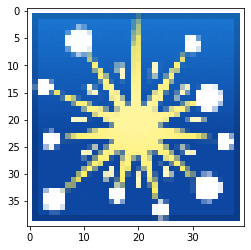

In [10]:
# Imports the target emoji
target = read_image("images/firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [11]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target = target.to(device)

model = MultipleCA(N_CHANNELS, n_CAs=2, device=device)

In [13]:
folder = "Pretrained_models/Virus/Virus lorenzo/"
model.CAs[0].load(folder + "firework_growing_64_96.pt")
model.CAs[1].load(folder + "firework_virus_ckp_2.pt")

Successfully loaded model!
Successfully loaded model!


In [14]:
for param in model.CAs[0].parameters():
    param.requires_grad = False

generator = VirusGenerator(N_CHANNELS, IMAGE_SIZE, 2, model, virus_rate=0.8, iter_func=ExponentialSampler(min=48, max=64))
pool = SamplePool(POOL_SIZE, generator)

In [8]:
wandb.init(project="quick_virus", entity="neural_ca")

wandb: Currently logged in as: lettera (use `wandb login --relogin` to force relogin)


In [16]:
L_target = NCALoss(pad(target, TARGET_PADDING), alpha_channels=[15, 16])
L_old_cells = OldCellLoss()

loss_function = CombinedLoss([L_target, L_old_cells], [ConstantWeight(64), ConstantWeight(64, constant=1e-3)])

In [17]:
wandb.init(mode="disabled")

In [18]:
params = model.CAs[1].parameters()

optimizer = torch.optim.Adam(params, lr=2e-3)
criterion = loss_function
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.3)

model.train_CA(optimizer, criterion, pool, n_epochs=1, skip_update=2, batch_size=3,
               scheduler=scheduler, kind="persistent", skip_damage=1, n_max_losses=1,
               evolution_iters=96)

/home/lettera/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([4, 48, 48])) that is different to the input size (torch.Size([3, 4, 48, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 1
avg loss: 0.04227556397261865


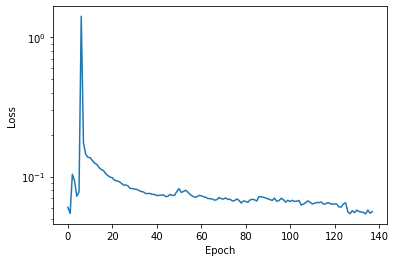

In [7]:
pl.plot(model.losses)
pl.xlabel("Epoch")
pl.ylabel("Loss")
pl.yscale("log")
pl.show()
# pl.savefig(fname="perturbation_regeneration_l=1_side=20_losses.png", dpi=200)

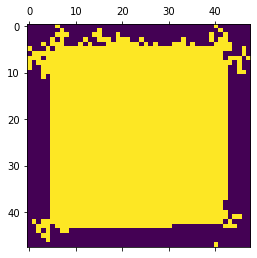

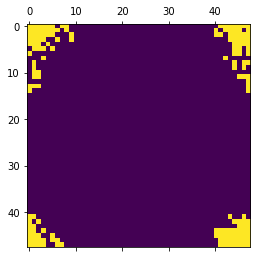

In [21]:
pl.matshow(inputs[0, -1].cpu()>0.1)
pl.matshow(inputs[0, -2].cpu()>0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


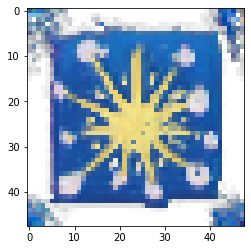

In [20]:
inputs = pool.sample(1)[0].detach().cuda()

inputs = model.evolve(inputs, 80)


imshow(state_to_image(inputs, [-1, -2])[0])